<a href="https://colab.research.google.com/github/Dahuginn/4yr_animerecommend/blob/main/%5BThesis%5Dgraph_split_node2vec.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install node2vec
!pip install stellargraph

In [77]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

import networkx as nx
import stellargraph as sg
from sklearn.model_selection import train_test_split
from stellargraph.data import EdgeSplitter
from sklearn.manifold import TSNE

from node2vec import Node2Vec

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import PredefinedSplit
from sklearn import svm
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression

from sklearn.metrics import roc_auc_score
from sklearn.model_selection import GridSearchCV, validation_curve, learning_curve

from google.colab import drive
drive.mount('/content/gdrive')
import sys
sys.path.append('/content/gdrive/My Drive')
import pickle

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


# Upload a graph created in the previous notebook

I decided to separate the workflow into two notebooks, because otherwise we could've overloaded colab's RAM. Creating a big df, then turning it into a graph, then training a node2vec model are memory consuming.

In [105]:
fh = open("/content/gdrive/My Drive/4 year/4000graph.graphml", "rb")
graph = nx.read_graphml(fh)
nx.info(graph)

'Graph with 1381 nodes and 186707 edges'

# Link prediction task

So far we've seen nice pictures of the graph we've created. But how are we going to use it to recommend animes to a user?? We need to formulate the task at hand using the language of machine learning.

We have links that exist in or graph, and we are going to sample the links that do not along with them. The former will be marked as "1", the latter - as "0". For each new pair of animes we are going to predoct whether the link between them could exist - this is the classification task. 
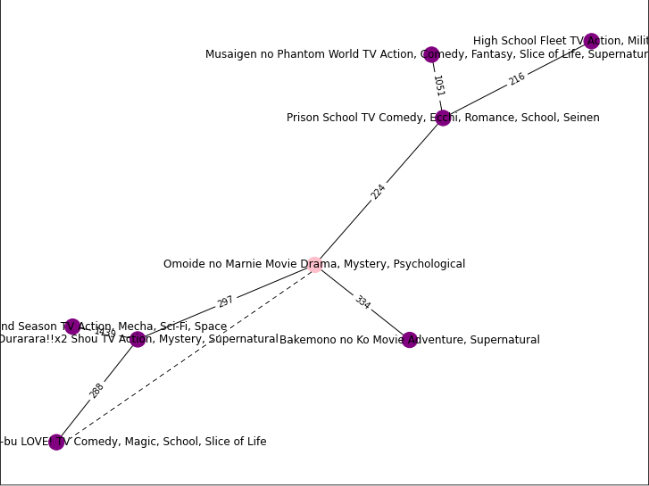

# Train-val-split

In [106]:
edge_splitter_test = EdgeSplitter(graph)
graph_test, examples_test, labels_test = edge_splitter_test.train_test_split(p=0.01, method="global")

print(nx.info(graph_test))

** Sampled 1867 positive and 1867 negative edges. **
Graph with 1381 nodes and 184840 edges


In [107]:
edge_splitter_train = EdgeSplitter(graph_test, graph)
graph_train, examples_train, labels_train = edge_splitter_train.train_test_split(p=0.01, method="global")

print(nx.info(graph_train))

** Sampled 1848 positive and 1848 negative edges. **
Graph with 1381 nodes and 182992 edges


In [108]:
pd.DataFrame(
    [("Training", len(examples_train), "Train classifier"),
     ("Test", len(examples_test), "Determine the best classifier score")],
     columns=("Split", "Num ", "Purpose")).set_index("Split")

,Num,Purpose
Split,,
Training,3696,Train classifier
Test,3734,Determine the best classifier score


# node2vec model

In [ ]:
node2vec = Node2Vec(graph_train, dimensions=128, walk_length=80, num_walks=10, weight_key='weight')
model = node2vec.fit(window=10, min_count=1)

In [ ]:
# pickle.dump(model, open('/content/gdrive/My Drive/4 year/node2vec4000.sav', 'wb'))

In [110]:
model = pickle.load(open('/content/gdrive/My Drive/4 year/node2vec4000.sav', 'rb'))

In [8]:
ne = model.wv.vectors
tsne2 = TSNE(n_components=2, random_state=42)
ne_2d = tsne2.fit_transform(ne)

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


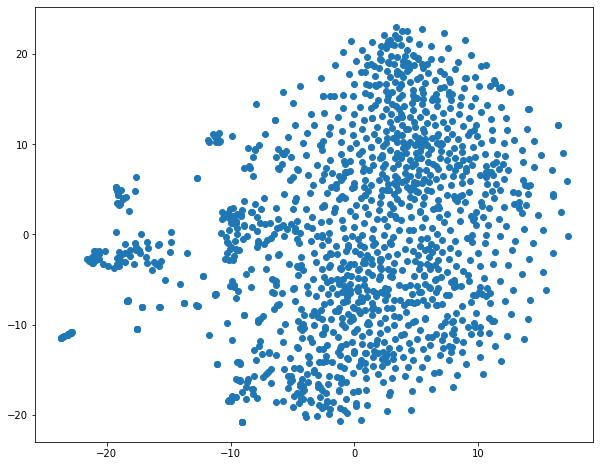

In [9]:
plt.figure(figsize=(10, 8))
plt.scatter(ne_2d[:, 0], ne_2d[:, 1])
plt.show()

In [10]:
nodes = []
for i in graph.nodes():
  nodes.append(i)

In [11]:
names_available = np.unique(nodes)

In [12]:
print(names_available[306], model.wv.get_vector(names_available[306]))

Dragon Ball Movie 1: Shen Long no Densetsu Movie Action, Adventure, Comedy, Fantasy, Shounen, Super Power [ 0.2536675  -0.0652265  -0.24051403  0.2031319   0.06303933  0.40321606
  0.05363801  0.11638362  0.27347773 -0.25031182 -0.07117012  0.02655062
  0.2898953  -0.10824783 -0.04134589 -0.22826928  0.20181084  0.1784216
 -0.08655833  0.08997286  0.2715392   0.1166527   0.14175607  0.09346616
  0.2686458   0.09285105 -0.04375963  0.22594008  0.06804812 -0.04915775
 -0.09468173  0.06507457  0.1638958   0.03825621  0.07600401 -0.07123578
  0.0781226   0.31325758  0.04748122 -0.17420332 -0.02191753  0.07676677
  0.17987253 -0.06192835  0.19576009  0.28281063 -0.28690854 -0.07676871
 -0.08511886 -0.12809128  0.19714959 -0.18858926  0.03805428  0.2147485
 -0.44267458  0.00306678 -0.02077867  0.0958362   0.1061364   0.03409855
 -0.00355894  0.3884879   0.0795657   0.17695218 -0.1929537   0.33760285
  0.02732782  0.13262735 -0.2535738  -0.19785933  0.22520939  0.22805779
 -0.02869935 -0.2207

In [14]:
for node, score in model.wv.most_similar('Dragon Ball Movie 1: Shen Long no Densetsu Movie Action, Adventure, Comedy, Fantasy, Shounen, Super Power'):
  print(node, score)

Dragon Ball: Super Saiya-jin Zetsumetsu Keikaku OVA Adventure, Fantasy, Martial Arts, Sci-Fi, Shounen, Super Power 0.8294494152069092
Dragon Ball Z: Atsumare! Gokuu World OVA Action, Adventure, Comedy, Fantasy, Martial Arts, Shounen, Super Power 0.8246987462043762
Dragon Ball Movie 4: Saikyou e no Michi Movie Action, Adventure, Comedy, Fantasy, Sci-Fi, Shounen, Super Power 0.8037557005882263
Dragon Ball Movie 3: Makafushigi Daibouken Movie Action, Adventure, Comedy, Fantasy, Sci-Fi, Shounen, Super Power 0.8010066151618958
Dragon Ball Kai: Mirai ni Heiwa wo! Goku no Tamashii yo Eien ni Special Action, Comedy, Fantasy, Sci-Fi, Shounen, Super Power 0.7962823510169983
Dragon Ball Movie 2: Majinjou no Nemuri Hime Movie Action, Adventure, Comedy, Fantasy, Sci-Fi, Shounen, Super Power 0.7956695556640625
Dragon Ball: Episode of Bardock Special Action, Adventure, Comedy, Fantasy, Martial Arts, Sci-Fi, Shounen, Super Power 0.7696738839149475
Dragon Ball Z Movie 04: Super Saiyajin da Son Gokuu Mo

# Classification

In [15]:
def operator_hadamard(u, v):
    return u * v


def operator_l1(u, v):
    return np.abs(u - v)


def operator_l2(u, v):
    return (u - v) ** 2


def operator_avg(u, v):
    return (u + v) / 2.0

In [16]:
def get_vectorized(link_features, model):
  s = []
  d = []
  for src, dst in link_features:
    s.append(model.wv[src])
    d.append(model.wv[dst])
  return np.array(s), np.array(d)

In [90]:
def scale(X, model, op):
  src, dst = get_vectorized(X, model)
  scaler = StandardScaler()
  X_train = op(src, dst)
  scaler.fit(X_train)
  scaled = scaler.transform(X_train)
  return scaled

In [99]:
binary_operators = [operator_hadamard, operator_l1, operator_l2, operator_avg]

logreg_param = {'penalty': ['l2'], 'C': np.logspace(0.01, 1, 5)}
Cltree_param = {'criterion': ['gini', 'entropy'], 'max_depth': [2,4,6,8,10,12]}
knn_param = {'n_neighbors': [3,5,7,9,11,13], 'weights': ['uniform', 'distance'], 'metric': ['euclidean', 'manhattan']}

In [127]:
def classify_choose(classifier, params):
  dictionary = {'op_name':[], 'best_score':[], 'best_params':[]}

  for op in binary_operators:
    # apply operator ans scal
    X_train_scaled = scale(examples_train, model, op)

    # choose model with the best roc-auc score
    grid = GridSearchCV(classifier(), params, scoring='roc_auc', cv=5)
    grid.fit(X_train_scaled, labels_train)

    dictionary['op_name'].append(op.__name__)
    dictionary['best_score'].append(grid.best_score_)
    dictionary['best_params'].append(grid.best_params_)
    
  return dictionary

In [124]:
print('Logistic Regression')
logreg_dict = pd.DataFrame(classify_choose(LogisticRegression, logreg_param)).set_index('op_name').sort_values('best_score')
logreg_dict

Logistic Regression


,best_score,best_params
op_name,,
operator_l1,0.737575,"{'C': 1.023292992280754, 'penalty': 'l2'}"
operator_l2,0.740296,"{'C': 3.198895109691398, 'penalty': 'l2'}"
operator_hadamard,0.868038,"{'C': 1.023292992280754, 'penalty': 'l2'}"
operator_avg,0.890567,"{'C': 1.023292992280754, 'penalty': 'l2'}"


In [117]:
print('Decision Trees')
tree_dict = pd.DataFrame(classify_choose(DecisionTreeClassifier, Cltree_param)).set_index('op_name').sort_values('best_score')
tree_dict

Decision Trees


,best_score,best_params
op_name,,
operator_l2,0.610707,"{'criterion': 'gini', 'max_depth': 6}"
operator_l1,0.614096,"{'criterion': 'gini', 'max_depth': 6}"
operator_hadamard,0.750131,"{'criterion': 'gini', 'max_depth': 4}"
operator_avg,0.765423,"{'criterion': 'gini', 'max_depth': 4}"


In [118]:
print('KNN')
knn_dict = pd.DataFrame(classify_choose(KNeighborsClassifier, knn_param)).set_index('op_name').sort_values('best_score')
knn_dict

KNN


,best_score,best_params
op_name,,
operator_l2,0.697287,"{'metric': 'euclidean', 'n_neighbors': 9, 'wei..."
operator_l1,0.718658,"{'metric': 'euclidean', 'n_neighbors': 13, 'we..."
operator_hadamard,0.735819,"{'metric': 'manhattan', 'n_neighbors': 13, 'we..."
operator_avg,0.845856,"{'metric': 'manhattan', 'n_neighbors': 13, 'we..."


# Evaluation

In [ ]:
node2vec_test = Node2Vec(graph_test, dimensions=128, walk_length=80, num_walks=10, weight_key='weight')
model_test = node2vec_test.fit(window=10, min_count=1)

Computing transition probabilities:   0%|          | 0/1381 [00:00<?, ?it/s]

In [ ]:
X_train_scaled = scale(examples_train, model, operator_avg)

In [ ]:
logreg_clf = LogisticRegression(C=1.023292992280754, penalty='l2')
logreg_clf.fit(X_train_scaled, labels_train)

In [125]:
X_test_scaled = scale(examples_test, model_test, operator_avg)
predicted = logreg_clf.predict_proba(X_test_scaled)
positive_column = list(logreg_clf.classes_).index(1)
print(roc_auc_score(labels_test, predicted[:, positive_column]))

In [ ]:
src_test, dst_test = get_vectorized(examples_test, model_test)
test = operator_avg(src_test, dst_test)

In [ ]:
embeddings = model_test.wv.vectors
tsne2 = TSNE(n_components=2, random_state=42)
embeddings_2d = tsne2.fit_transform(operator_avg(test))

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


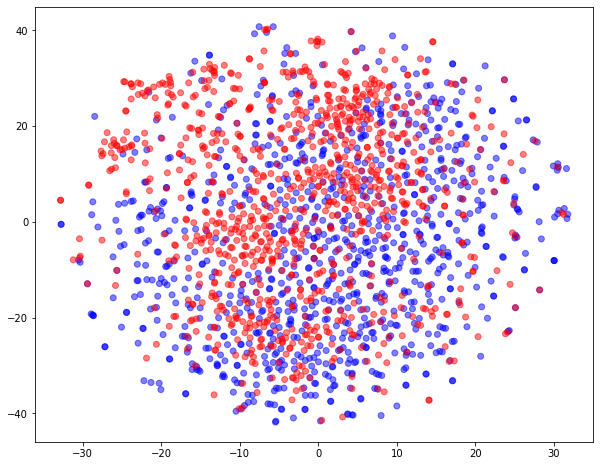

In [ ]:
plt.figure(figsize=(10, 8))
plt.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1], c=np.where(labels_test == 1, "b", "r"), alpha=0.5)
plt.show()